In [3]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import import_ipynb
from operator import itemgetter, attrgetter
from randomPermutation import create_random_permutation
from universalHashFunctions import create_random_hash_function


data = np.genfromtxt('ratings_100users.csv', delimiter=',', names=True)

userList = {}
movieMap = {}
movieList = {}

i = 0

for index, values in np.ndenumerate(data):
    
    if values[0] not in userList.keys():
        userList[int(values[0])] = []
    userList[values[0]].append(int(values[1]))
    
    if values[1] not in movieMap.values():
        movieMap[i] = int(values[1])
        i += 1 
        
    if values[1] not in movieList.keys():
        movieList[int(values[1])] = []
    
    movieList[int(values[1])].append(int(values[0]))
    
inv_map = {v: k for k, v in movieMap.items()}      #Inverse MovieMap
inv_map = sorted(inv_map.keys())


# MinHash algorithm 

In [4]:
def minHash (n):
    
    sig = []
    permutation = []
    for i in range(n): 
        permutation.append(create_random_permutation(len(userList)))  # random user's permutations  
    
    for i in range (n):
        tempArray = []
        for col in movieMap:
            tempArray.append(sys.maxsize)
        sig.append(tempArray)
        
    #SIN nxN
    
    for col in movieMap: 
        for row in userList:  
            for movie in userList[row]: 
                if (movie == inv_map[col]):   #check with movieId order
                    for i in range (n):
                        if permutation[i][row-1] < sig[i][col]:
                            sig[i][col] = permutation[i][row-1]
           
    return sig 

# Locality-sensitive hashing creating candidates pairs of probably similar objects 

In [11]:
def LSH(sig,n,bands,rows):
    
    #SIG nxK
    myHashFunction = create_random_hash_function(1000)
      
    similarCouples = []
    
    bandSize = int(n / bands)

    
    for b in range(0,n,bandSize):
        bin = {}
        for movieId in range(20):   #Impement for first 20 movies sorted with movieId
            mylist = []
            movie = inv_map[movieId]
            for r  in  range (b,b+rows):
                if sig[r][movie] < 10 :  #if number has 1 digit form 
                    mylist.append("0"+str(sig[r][movieId]))
                else:
                    mylist.append(str(sig[r][movieId]))
                
            subSigNumber = int(''.join(map(str,mylist)))
            hashingResult = int(myHashFunction(subSigNumber))
            
            if hashingResult not in bin.keys():
                bin[hashingResult] = []
            else:
                for i in bin[hashingResult]: 
                    tempArray = []
                    tempArray.append(i)
                    tempArray.append(movie)
                    similarCouples.append(tempArray)
            bin[hashingResult].append(movie)  
            
    return similarCouples

# SignatureSimilarity based on sig matrix was produced minHash algorithm

In [12]:
def signatureSimilarity(movieId1,movieId2,n):
    
    
    for value in range(len(inv_map)):  
        if inv_map[value] == movieId1 :
            movieId1 = value
        if inv_map[value] == movieId2 :
            movieId2 = value
            
    similarities = 0
    for i in range(n):
        if (sig[i][movieId1]  == sig[i][movieId2] ):
            similarities += 1   
        
    return similarities / n






# Jaccard Similarity used for Ground Truth 

In [13]:
def jaccardSimilarity(movieId1,movieId2):
    s1 = set( movieList[movieId1] )
    s2 = set( movieList[movieId2] )
    JACCARD = ( len(s1.intersection(s2)) / len(s1.union(s2)) )
    return (JACCARD)


# Experiment using first 20 movies using minHash algorithm 


FP =  12
FN =  13
PRECISION =  0.5555555555555556
RECALL =  0.5357142857142857
F1 =  0.5454545454545454



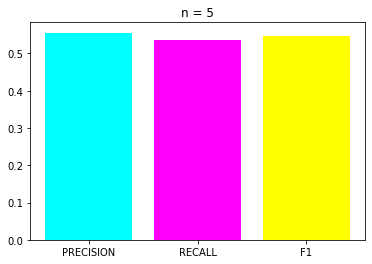

FP =  14
FN =  10
PRECISION =  0.5625
RECALL =  0.6428571428571429
F1 =  0.6000000000000001



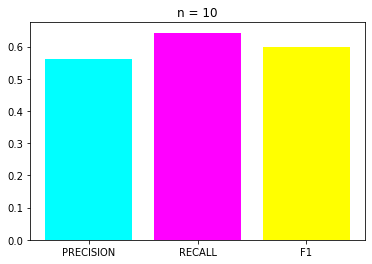

FP =  20
FN =  6
PRECISION =  0.5238095238095238
RECALL =  0.7857142857142857
F1 =  0.6285714285714286



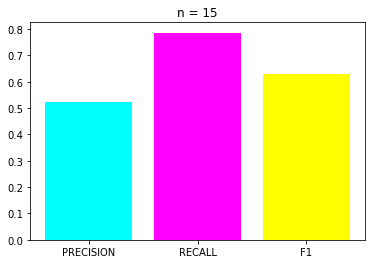

FP =  21
FN =  6
PRECISION =  0.5116279069767442
RECALL =  0.7857142857142857
F1 =  0.619718309859155



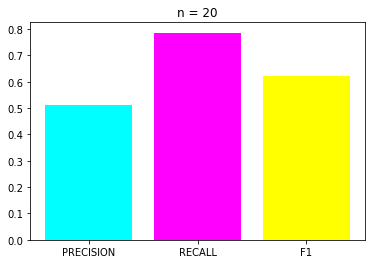

FP =  10
FN =  8
PRECISION =  0.6666666666666666
RECALL =  0.7142857142857143
F1 =  0.689655172413793



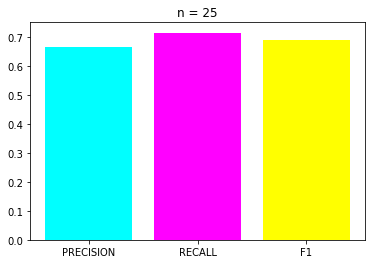

FP =  11
FN =  7
PRECISION =  0.65625
RECALL =  0.75
F1 =  0.7



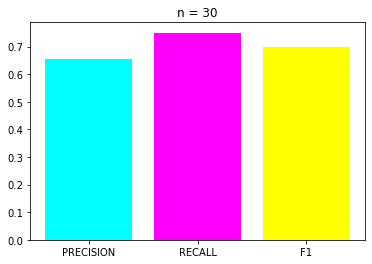

FP =  16
FN =  5
PRECISION =  0.5897435897435898
RECALL =  0.8214285714285714
F1 =  0.6865671641791046



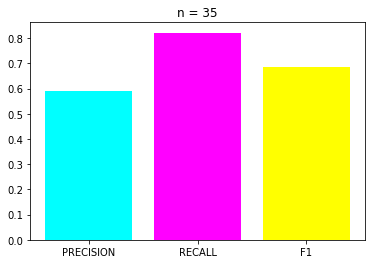

FP =  17
FN =  5
PRECISION =  0.575
RECALL =  0.8214285714285714
F1 =  0.676470588235294



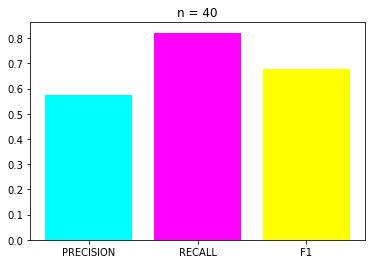

<Figure size 432x288 with 0 Axes>

In [14]:
s = 0.25 #THRESHOLD

totalPairsSize = 20 # 20 for file ratings_100users.csv  OR 100 for file ratings.csv 

sig = minHash(40)

sig = np.asarray(sig)
np.savetxt("SIG.csv", sig,fmt='%i', delimiter=",")



relativeElements = 0
notCalculatedRelativeElements = True
for n in range(5,45,5):
   
    falsePositives = 0
    falseNegatives = 0
    
    for i in range (totalPairsSize):
        for j in range (1,totalPairsSize-i):
            sigSim = signatureSimilarity(inv_map[i],inv_map[j+i], n)
            jacSim = jaccardSimilarity(inv_map[i],inv_map[j+i])
            
            if (sigSim >= s and jacSim < s):
                falsePositives += 1
            if (sigSim < s and jacSim >= s):
                falseNegatives += 1
            if (notCalculatedRelativeElements): 
                
                if(jaccardSimilarity(inv_map[i],inv_map[j+i]) >= s):
                    relativeElements += 1
    
    notCalculatedRelativeElements = False
      
    truePositives = relativeElements - falseNegatives              
    
    
    PRECISION = truePositives / ( truePositives + falsePositives )

    RECALL = truePositives / ( truePositives + falseNegatives )

    F1 = 2 * RECALL * PRECISION / ( RECALL + PRECISION )
    
    
    print("FP = ", falsePositives)
    print("FN = ", falseNegatives)
    print("PRECISION = ", PRECISION)
    print("RECALL = ", RECALL)
    print("F1 = ", F1)
    print()
    
  
    # x-coordinates of left sides of bars  
    left = [1, 2, 3] 
    
    
    # values of results 
    values = [PRECISION,RECALL,F1] 

    # labels for bars 
    tick_label = ['PRECISION', 'RECALL', 'F1'] 

    # plotting a bar chart 
    plt.bar(left, values, tick_label = tick_label, 
            width = 0.8, color = ['cyan', 'magenta','yellow',]) 

    
    # plot title 
    plt.title("n = " + str(n)) 

    # function to show the plot 
    plt.show() 
    
    # Save plot 
    plt.savefig('n =' + str(n) + '.png')

    

# # Experiment using first 20 movies using  Locality-sensitive hashing technique 

FP =  10
FN =  0
( b =  20 , r =  2 )
PRECISION =  0.7368421052631579
RECALL =  1.0
F1 =  0.8484848484848484



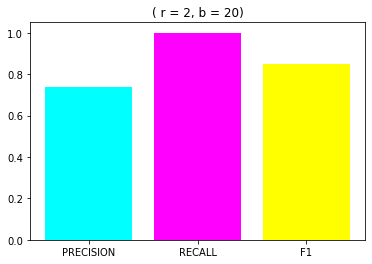

FP =  7
FN =  0
( b =  10 , r =  4 )
PRECISION =  0.8
RECALL =  1.0
F1 =  0.888888888888889



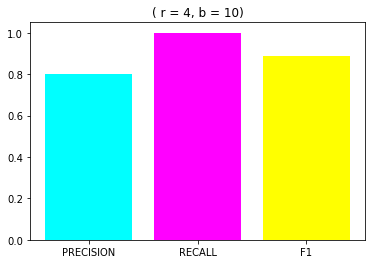

FP =  9
FN =  2
( b =  8 , r =  5 )
PRECISION =  0.7428571428571429
RECALL =  0.9285714285714286
F1 =  0.8253968253968255



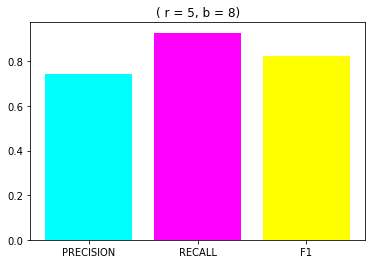

FP =  14
FN =  1
( b =  5 , r =  8 )
PRECISION =  0.6585365853658537
RECALL =  0.9642857142857143
F1 =  0.782608695652174



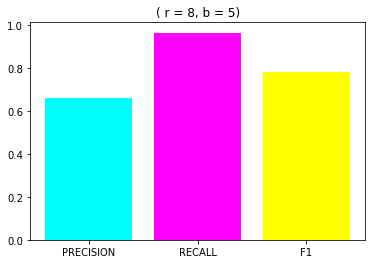

FP =  4
FN =  0
( b =  4 , r =  10 )
PRECISION =  0.875
RECALL =  1.0
F1 =  0.9333333333333333



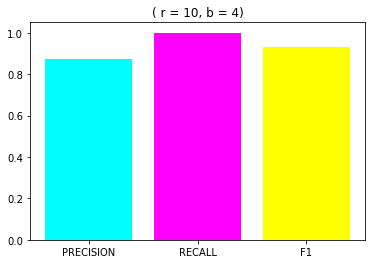

FP =  3
FN =  0
( b =  2 , r =  20 )
PRECISION =  0.9032258064516129
RECALL =  1.0
F1 =  0.9491525423728813



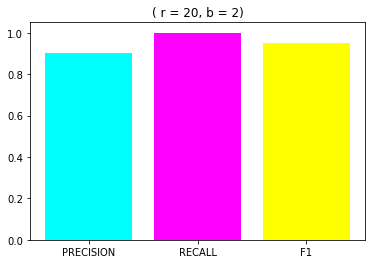

<Figure size 432x288 with 0 Axes>

In [15]:
s = 0.25
totalPairsSize = 20
n = 40 # n = b*r
#TODO SIG.CSV


testListNumbers = [2,4,5,8,10,20]

for r in testListNumbers:
    b = int(n/r)
    falsePositives = 0
    falseNegatives = 0
    
    similarCouples = LSH(sig,n,b,r)
    
    for i in similarCouples:
            
            sigSim = signatureSimilarity(inv_map[i[0]],inv_map[i[1]], n)
            jacSim = jaccardSimilarity(inv_map[i[0]],inv_map[i[1]])
            
            if (sigSim < s and jacSim >= s):
                falseNegatives += 1
            if (sigSim >= s and jacSim < s):
                falsePositives += 1
            
    truePositives = relativeElements - falseNegatives              

    PRECISION = truePositives / ( truePositives + falsePositives )

    RECALL = truePositives / ( truePositives + falseNegatives )

    F1 = 2 * RECALL * PRECISION / ( RECALL + PRECISION )
    
    print("FP = ", falsePositives)
    print("FN = ", falseNegatives)
    print("( b = ",b,", r = ", r ,")")
    print("PRECISION = ", PRECISION)
    print("RECALL = ", RECALL)
    print("F1 = ", F1)
    print()
    
    
    # x-coordinates of left sides of bars  
    left = [1, 2, 3, ] 
    
    
    # values of results 
    values = [PRECISION,RECALL,F1] 

    # labels for bars 
    tick_label = ['PRECISION', 'RECALL', 'F1'] 

    # plotting a bar chart 
    plt.bar(left, values, tick_label = tick_label, 
            width = 0.8, color = ['cyan','magenta','yellow']) 

    
    # plot title 
    title = "( r = "+ str(r) + ", b = "+ str(b) + ")"
    
    plt.title(title) 

    # function to show the plot 
    plt.show() 
    
    # Save plot 
    plt.savefig( title + '.png')
    
    